# Replacing LAYER command of Vel2Grid by producing SimulPS txt files

This notebook produces the text files needed for Vel2Grid based on Trugman, 2024, to use the Savard velocity model for travel-time grids (Loïc 1+2+3 notebooks + mine Matching_VelModel). *Notes at the end on the differences.*

To-do: the text file are produced, I have to verify one last time that all the process is correct and that the velocity model is ready and well used for Vel2Grid. Maybe the polygon is useless, let's see that too

In [26]:
import os
import json
import numpy as np
import pandas as pd
import xarray as xr
from scipy import interpolate
import matplotlib.pyplot as plt
from pyproj import CRS, Transformer
from scipy.interpolate import griddata
base_dir = '/Users/lpapin/Documents/phd/projects/sw4/nonlinloc/'

## Preparation of the velocity model

### Get a subset of it like in Matching_VelModel.ipynb

In [2]:
# Define the limits of the subset (defined previously in Matching_VelModel.ipynb)
latMin, latMax, lonMin, lonMax = 48, 49.3, -124.5, -123

# Load the model and get a subset
velmodel=pd.read_csv('Savard_VpVs.txt', sep='\s+',header=None, names=['lon', 'lat', 'depth', 'vp', 'vs', 'DWS'])
velmodel = velmodel.drop(columns=['DWS'])
print(velmodel, '\nbecomes')
velmodel_subset=velmodel[(velmodel['lat']>=latMin)&(velmodel['lat']<=latMax)&(velmodel['lon']<=lonMax)&(velmodel['lon']>=lonMin)]
print(velmodel_subset)

              lon        lat  depth        vp        vs
0     -126.672510  46.951514    0.0  4.956299  2.864755
1     -126.675741  47.077409    0.0  4.966347  2.870762
2     -126.678979  47.203304    0.0  4.976305  2.876411
3     -126.681999  47.320203    0.0  4.968136  2.871618
4     -126.685262  47.446098    0.0  4.957817  2.865878
...           ...        ...    ...       ...       ...
36987 -120.554069  50.494531   93.0  8.245674  4.766323
36988 -120.549634  50.620422   93.0  8.249911  4.768947
36989 -120.545500  50.737325   93.0  8.257427  4.772954
36990 -120.541032  50.863220   93.0  8.261029  4.774880
36991 -120.536556  50.989115   93.0  8.264282  4.776913

[36992 rows x 5 columns] 
becomes
              lon        lat  depth        vp        vs
417   -124.486230  48.057585    0.0  4.015196  2.321009
418   -124.486825  48.183476    0.0  3.422538  1.978356
419   -124.487386  48.300378    0.0  3.399979  1.965315
420   -124.487988  48.426274    0.0  4.170433  2.434671
421   -124.48

### Simple interpolation

In [3]:
# Define latitude, longitude, and depth ranges for the grid 
degrees_step = 0.05
lats = 10 * np.arange(latMin, latMax, degrees_step) / 10
lons = 10 * np.arange(lonMin, lonMax, degrees_step) / 10
depths = velmodel['depth'].unique().tolist()
lon_grid, lat_grid, depth_grid = np.meshgrid(lons, lats, depths)
# Grid defined for the subset
grid = np.vstack([lon_grid.ravel(), lat_grid.ravel(), depth_grid.ravel()]).T

In [4]:
# Interpolating the velocity model ###take some time
grid_vp = griddata((velmodel['lon'],velmodel['lat'],velmodel['depth']), velmodel['vp'], 
                    (grid), method='linear')
grid_vs = griddata((velmodel['lon'],velmodel['lat'],velmodel['depth']), velmodel['vs'], 
                    (grid), method='linear')
velmodel_interp = pd.DataFrame(np.hstack((grid,
                                      grid_vp.reshape(len(lats)*len(lons)*len(depths),1),
                                      grid_vs.reshape(len(lats)*len(lons)*len(depths),1))), 
                           columns=['lon', 'lat', 'depth', 'vp', 'vs'])
print(velmodel_interp)

          lon    lat  depth        vp        vs
0     -124.50  48.00    0.0  4.243970  2.453184
1     -124.50  48.00    3.0  4.579647  2.647116
2     -124.50  48.00    6.0  4.929161  2.849226
3     -124.50  48.00    9.0  5.413106  3.128895
4     -124.50  48.00   12.0  5.818082  3.363077
...       ...    ...    ...       ...       ...
24955 -123.05  49.25   81.0  8.041543  4.648209
24956 -123.05  49.25   84.0  8.108870  4.687266
24957 -123.05  49.25   87.0  8.176657  4.726511
24958 -123.05  49.25   90.0  8.248983  4.768301
24959 -123.05  49.25   93.0  8.307589  4.801934

[24960 rows x 5 columns]


In [5]:
# Check for NaN values
vp_nan_count = np.isnan(velmodel_interp['vp']).sum()
vs_nan_count = np.isnan(velmodel_interp['vs']).sum()
assert vp_nan_count == 0 and vs_nan_count == 0, "NaN values found in Vp or Vs. Fix the NaN values before proceeding."

### Save to netdcf from xarray

In [27]:
# Change the DataFrame in Dataset to save in netdcf
df_pivot = velmodel_interp.pivot_table(index=['lat', 'lon', 'depth'], values=['vp', 'vs'])
ds = xr.Dataset.from_dataframe(df_pivot)
ds.to_netcdf("velmodel_interp.nc")

## Polygon definition (not sure it's needed)

### Create the json file

In [7]:
# Functions to create the polygon of the subset for projection
def write_json(new_data, filename='svi_poly.json'):
    with open(filename, 'w') as file:
        json.dump([], file)
    with open(filename, 'r+') as file:
        file_data = file.read().strip()
        if file_data == '':
            file_data = []
        else:
            file_data = json.loads(file_data)
        file_data.append(new_data)
        file.seek(0)
        json.dump(file_data, file, indent=4)

def create_dict_std_param(poly_id, min_lon, max_lon, min_lat, max_lat):
    dictionary = {
        "poly_id": poly_id,
        "olon": (min_lon + max_lon) / 2,
        "olat": (min_lat + max_lat) / 2,
        "plat1": min_lat,
        "plat2": max_lat,
        "xmin": -124.0,
        "xmax": 124.0,
        "xsep": 2.0,
        "ymin": -124.0,
        "ymax": 124.0,
        "ysep": 2.0,
        "zmin": -4.0,
        "zmax": 100.0,
        "zsep": 1.0,
        "minlon": min_lon,
        "maxlon": max_lon,
        "minlat": min_lat,
        "maxlat": max_lat,
    }
    return dictionary

In [8]:
# Only the subset region
rectangles = [[1, lonMin, latMin, lonMax, latMax]]
subset_polygon = pd.DataFrame(rectangles, columns=['poly_id', 'min_lon', 'min_lat', 'max_lon', 'max_lat'])

# Write the json file
for i, row in subset_polygon.iterrows():
    write_json(create_dict_std_param(row.poly_id, row.min_lon, row.max_lon, row.min_lat, row.max_lat))

with open("svi_poly.json", 'r') as file:
    polygon = json.load(file)

# Velocity model subset parameters
polygon[0]

{'poly_id': 1.0,
 'olon': -123.75,
 'olat': 48.65,
 'plat1': 48.0,
 'plat2': 49.3,
 'xmin': -124.0,
 'xmax': 124.0,
 'xsep': 2.0,
 'ymin': -124.0,
 'ymax': 124.0,
 'ysep': 2.0,
 'zmin': -4.0,
 'zmax': 100.0,
 'zsep': 1.0,
 'minlon': -124.5,
 'maxlon': -123.0,
 'minlat': 48.0,
 'maxlat': 49.3}

## Projection of the model on the polygon (degrees to km)

This part define the parameters of the projection to transform the coordinates in lon and lat of the stations, the events, and the velocity model in km, and execute the projection.

### Parameters of the projection

In [9]:
# Parameters for projection (keep the original lines in case later multiple polygons)
poly = 1
pproj = "lcc" # "tmerc"
maxR = "200R"
poly_param = polygon[poly-1]

# Origin for pyproj projection
olat, olon = poly_param['olat'], poly_param['olon']

# Projection lcc only
plat1, plat2 = poly_param['plat1'], poly_param['plat2']

# Cartesian grid bounds for velocity model
xmin, xmax, xsep = poly_param['xmin'], poly_param['xmax'], poly_param['xsep']
ymin, ymax, ysep = poly_param['ymin'], poly_param['ymax'], poly_param['ysep']
zmin, zmax, zsep = poly_param['zmin'], poly_param['zmax'], poly_param['zsep']

In [10]:
# Projection setup
crs1 = CRS.from_proj4("+proj=longlat +ellps=WGS84")
if pproj == "lcc":
    crs2 = CRS.from_proj4("+proj={:} +ellps=WGS84 +lat_0={:.4f} +lon_0={:.4f} +lat_1={:.4f} +lon_2={:.4f} +units=km".format(
        pproj,olat,olon,plat1,plat2))
else:
    crs2 = CRS.from_proj4("+proj={:} +ellps=WGS84 +lat_0={:.4f} +lon_0={:.4f} +units=km".format(
        pproj,olat,olon))

# From lon/lat to km et inversement
proj = Transformer.from_crs(crs1,crs2)
iproj = Transformer.from_crs(crs2,crs1)

### Project the stations

The stations have been choosen so it already fits in the subset, if changes are made for boundaries or stations, it is better to check that the stations fits in the rectangle.

In [50]:
# Load the stations
stas=pd.read_csv('stations.csv', usecols=[0, 1, 2, 3, 4],
                    names=['net', 'sta', 'lat', 'lon', 'elev'], header=0, delimiter='|')
print(stas['sta'].to_list())

['BPCB', 'GLBC', 'JRBC', 'LCBC', 'MGCB', 'PHYB', 'SHDB', 'SHVB', 'SOKB', 'TWBB', 'LZB', 'NLLB', 'PFB', 'PGC', 'SNB', 'VGZ', 'YOUB', 'GOWB', 'KLNB', 'SILB', 'SSIB', 'TSJB', 'TWGB', 'TWKB']


In [51]:
# Find the boundaries for projection
staslat0, staslat1 = stas['lat'].min(), stas['lat'].max()
staslon0, staslon1 = stas['lon'].min(), stas['lon'].max()
staselv0, staselv1 = stas['elev'].min(), stas['elev'].max()
print(f"Minimum longitude: {staslon0:.3f}, maximum longitude: {staslon1:.3f}")
print(f"Minimum latitude: {staslat0:.3f}, maximum latitude: {staslat1:.3f}")
print(f"Minimum elevation: {staselv0:.0f}, maximum elevation: {staselv1:.0f}")

Minimum longitude: -124.454, maximum longitude: -123.172
Minimum latitude: 48.395, maximum latitude: 49.227
Minimum elevation: 0, maximum elevation: 794


In [52]:
# Find the center point
staslonC, staslatC = np.round(0.5*(staslon0+staslon1),4), np.round(0.5*(staslat0+staslat1),4)
print(f"Center point lon: {staslonC:.3f}, lat: {staslatC:.3f}")

Center point lon: -123.813, lat: 48.811


In [53]:
# New coordinates with projection
stasxproj, stasyproj = proj.transform(stas['lon'], stas['lat'])
stas['x'] = stasxproj
stas['y'] = stasyproj
print(f"x min: {stas['x'].min():.3f}, x max: {stas['x'].max():.3f}")
print(f"y min: {stas['y'].min():.3f}, y max: {stas['y'].max():.3f}")

x min: -51.959, x max: 42.465
y min: -28.388, y max: 64.214


In [54]:
# How it looks
stas

,net,sta,lat,lon,elev,x,y
0,C8,BPCB,48.9236,-123.7045,31.0,3.334840,30.429742
1,C8,GLBC,48.3960,-123.6363,100.0,8.419963,-28.239916
2,C8,JRBC,48.3957,-123.9600,20.0,-15.551460,-28.258305
3,C8,LCBC,48.4834,-124.2619,100.0,-37.843552,-18.401424
4,C8,MGCB,48.6317,-123.6808,236.0,5.101026,-2.032849
5,C8,PHYB,49.0828,-123.8431,39.0,-6.802213,48.140195
6,C8,SHDB,48.7970,-123.6360,55.0,8.376241,16.354546
7,C8,SHVB,48.4723,-123.6360,69.0,8.429633,-19.755182
8,C8,SOKB,48.3947,-123.6731,45.0,5.694913,-28.387845
9,C8,TWBB,48.5846,-124.0920,122.0,-25.233430,-7.217089


### Project the events

Same thing as for the stations, the events actually made the boundaries of the rectangle (Matching_VelModel.ipynb) so if any changes are made, a filter can be added to keep only the events of the region.

In [77]:
# Prepare the events
events = pd.read_csv('lfe_svi.txt', index_col=0, dtype={'date': str, 'hour': str, 'lfe_family': str})
events['date'] = '20' + events['date']
events['date'] = pd.to_datetime(events['date'], format='%Y%m%d')
events['hour'] = events['hour'].str.zfill(2)
events['OT'] = events['date'] + pd.to_timedelta(events['hour'].astype(int), unit='h') + pd.to_timedelta(events['second'], unit='s')
events = events.drop(columns=['hour', 'second'])
events = events.sort_values(by='OT', ascending=True)
events.reset_index(inplace=True)
events.index.name = 'Index'

In [78]:
# Load the locations
sav_family_phases = np.load('sav_family_phases.npy', allow_pickle=True).item()

# Get the families and match the locations
nb_family = events['lfe_family'].unique()
nb_family.sort()
eventLocs = []
for fam in nb_family:
    eqLoc_values = sav_family_phases[fam]['eqLoc']
    lon_family, lat_family, z_family = eqLoc_values
    lon_family = lon_family * -1
    eventLocs.append([fam, lon_family, lat_family, z_family])
eventLocs = pd.DataFrame(eventLocs, columns=['Index', 'lon', 'lat', 'depth'])
eventLocs.set_index('Index', inplace=True)  # Set family as index

# Merge events with eventLocs on 'lfe_family' and 'Index'
merged_events = events.merge(eventLocs, how='left', left_on='lfe_family', right_index=True)
merged_events

,lfe_family,date,Mw,OT,lon,lat,depth
Index,,,,,,,
0,045,2003-02-26,1.513,2003-02-26 00:15:02.050,-123.864833,48.349667,31.32
1,132,2003-02-26,1.516,2003-02-26 00:49:42.850,-123.890000,48.308000,29.89
2,032,2003-02-26,1.516,2003-02-26 01:27:25.575,-123.787167,48.179167,29.60
3,032,2003-02-26,1.583,2003-02-26 01:28:08.375,-123.787167,48.179167,29.60
4,066,2003-02-26,1.850,2003-02-26 01:47:36.225,-123.834667,48.196833,29.51
...,...,...,...,...,...,...,...
269418,078,2013-10-13,1.150,2013-10-13 14:30:58.400,-123.878833,48.712500,39.75
269419,275,2013-10-13,1.352,2013-10-13 15:01:46.800,-123.893833,48.880167,39.91
269420,263,2013-10-13,1.360,2013-10-13 15:04:50.000,-123.322333,48.444667,38.82


In [79]:
# Find the boundaries for projection
events = merged_events
eventslon0, eventslon1 = events['lon'].quantile([0,1]).values
eventslat0, eventslat1 = events['lat'].quantile([0,1]).values
eventslonM, eventslatM = (eventslon0+eventslon1)/2, (eventslat0+eventslat1)/2
print(f"Middle longitude: {eventslonM}")
print(f"Middle latitude: {eventslatM}")

Middle longitude: -123.7195
Middle latitude: 48.52466666666666


In [82]:
# New coordinates with projection
eventsxproj, eventsyproj = proj.transform(events['lon'],events['lat'])
events['x'] = eventsxproj
events['y'] = eventsyproj

# Useful for NonLinLoc
print("Projected seismicity bounds:")
print(f"x min: {events['x'].min():.3f}, x max: {events['x'].max():.3f}")
print(f"y min: {events['y'].min():.3f}, y max: {events['y'].max():.3f}")

Projected seismicity bounds:
x min: -43.280, x max: 48.148
y min: -59.028, y max: 31.245


In [83]:
# How it looks
events

,lfe_family,date,Mw,OT,lon,lat,depth,x,y
Index,,,,,,,,,
0,045,2003-02-26,1.513,2003-02-26 00:15:02.050,-123.864833,48.349667,31.32,-8.511565,-33.392049
1,132,2003-02-26,1.516,2003-02-26 00:49:42.850,-123.890000,48.308000,29.89,-10.385355,-38.022231
2,032,2003-02-26,1.516,2003-02-26 01:27:25.575,-123.787167,48.179167,29.60,-2.763972,-52.356756
3,032,2003-02-26,1.583,2003-02-26 01:28:08.375,-123.787167,48.179167,29.60,-2.763972,-52.356756
4,066,2003-02-26,1.850,2003-02-26 01:47:36.225,-123.834667,48.196833,29.51,-6.294244,-50.389529
...,...,...,...,...,...,...,...,...,...
269418,078,2013-10-13,1.150,2013-10-13 14:30:58.400,-123.878833,48.712500,39.75,-9.481834,6.958637
269419,275,2013-10-13,1.352,2013-10-13 15:01:46.800,-123.893833,48.880167,39.91,-10.551011,25.607873
269420,263,2013-10-13,1.360,2013-10-13 15:04:50.000,-123.322333,48.444667,38.82,31.640343,-22.746564


### Load the velocity model in netdcf + examples

In [14]:
# Load the xarray
velocities = xr.open_dataset("velmodel_interp.nc")
velocities

<xarray.Dataset> Size: 400kB
Dimensions:  (depth: 32, lon: 30, lat: 26)
Coordinates:
  * depth    (depth) float64 256B 0.0 3.0 6.0 9.0 12.0 ... 84.0 87.0 90.0 93.0
  * lon      (lon) float64 240B -124.5 -124.5 -124.4 ... -123.2 -123.1 -123.1
  * lat      (lat) float64 208B 48.0 48.05 48.1 48.15 ... 49.1 49.15 49.2 49.25
Data variables:
    vp       (lat, lon, depth) float64 200kB ...
    vs       (lat, lon, depth) float64 200kB ...

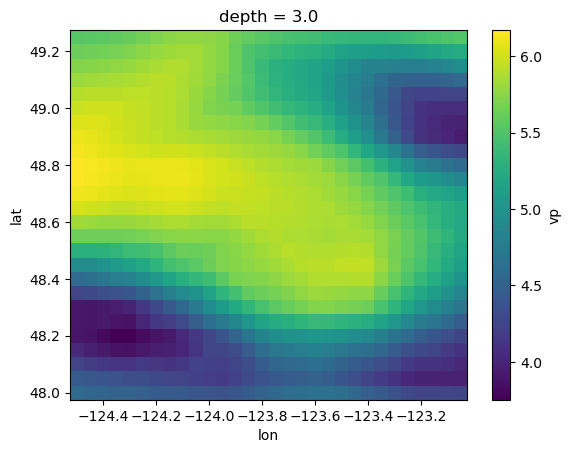

In [15]:
# Plot a fixed depth example
velocities['vp'].sel(depth = 3).plot()
plt.show()

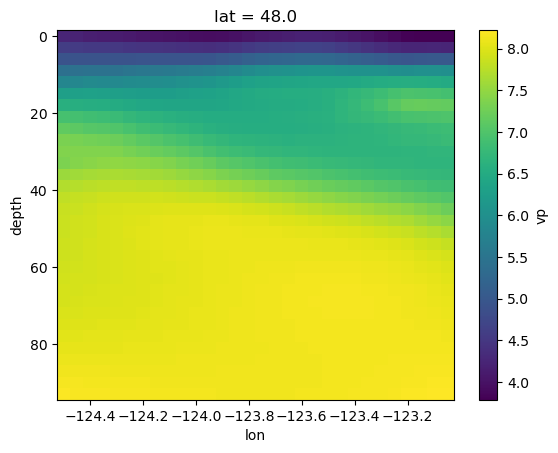

In [16]:
# Plot a fixed latitude example
velocities['vp'].sel(lat = 48).plot(y = 'depth')
plt.gca().invert_yaxis()
plt.show()

### Project the velocities

In [95]:
# Create a grid with Cartesian coordinates
xgrid, ygrid = np.meshgrid(
    np.arange(xmin,xmax+xsep/2,xsep),
    np.arange(ymin,ymax+ysep/2,ysep))

# Projection in lon/lat of the grid
lon_grid, lat_grid = iproj.transform(xgrid,ygrid)
print(lon_grid)
print()
print(lat_grid)

[[-125.39657936 -125.3700295  -125.34347927 ... -122.15652073
  -122.1299705  -122.10342064]
 [-125.39714665 -125.37058766 -125.34402828 ... -122.15597172
  -122.12941234 -122.10285335]
 [-125.39771433 -125.37114619 -125.34457767 ... -122.15542233
  -122.12885381 -122.10228567]
 ...
 [-125.46879943 -125.44108582 -125.41337177 ... -122.08662823
  -122.05891418 -122.03120057]
 [-125.46941758 -125.44169401 -125.41397    ... -122.08603
  -122.05830599 -122.03058242]
 [-125.47003617 -125.44230263 -125.41456866 ... -122.08543134
  -122.05769737 -122.02996383]]

[[47.52292249 47.52330353 47.52367837 ... 47.52367837 47.52330353
  47.52292249]
 [47.54090644 47.54128761 47.54166259 ... 47.54166259 47.54128761
  47.54090644]
 [47.55889038 47.55927168 47.55964678 ... 47.55964678 47.55927168
  47.55889038]
 ...
 [49.71633479 49.71673222 49.71712319 ... 49.71712319 49.71673222
  49.71633479]
 [49.73430387 49.73470144 49.73509255 ... 49.73509255 49.73470144
  49.73430387]
 [49.75227272 49.75267042 49

In [96]:
# Output grid
x_flat, y_flat = np.ravel(xgrid), np.ravel(ygrid)
out_lonflat, out_latflat = np.ravel(lon_grid), np.ravel(lat_grid)

# Original velocity model
longrid, latgrid = np.meshgrid(
    np.asarray(velocities.lon), np.asarray(velocities.lat))
vel_lonflat = np.ravel(longrid)
vel_latflat = np.ravel(latgrid)

In [88]:
# Velocities interpolation on depths
out_obs = np.vstack([out_lonflat, out_latflat]).T
vel_obs = np.vstack([vel_lonflat, vel_latflat]).T
xvals, yvals, zvals, vpvals, vsvals = [], [], [], [], []
for z in depths:
    vel_vp = np.ravel(velocities['vp'].interp(depth = z, method = 'linear').values)
    vel_vs = np.ravel(velocities['vs'].interp(depth = z, method = 'linear').values)
    # Interpolation process
    out_vp = interpolate.griddata(vel_obs, vel_vp, out_obs, method="linear")
    out_vs = interpolate.griddata(vel_obs, vel_vs, out_obs, method="linear")
    # Update the values
    xvals.append(x_flat)
    yvals.append(y_flat)
    zvals.append(z + np.zeros(y_flat.size))
    vpvals.append(out_vp) # km/s
    vsvals.append(out_vs) # km/s

# Completed everything
print("Done")

Done


In [102]:
# Make a DataFrame
odf = pd.DataFrame({
    "x": np.hstack(xvals),
    "y": np.hstack(yvals),
    "z": np.hstack(zvals),
    "vp": np.hstack(vpvals),
    "vs": np.hstack(vsvals),
})

# Grid points
xg = odf["x"].unique()
yg = odf["y"].unique()
zg = odf["z"].unique()
nx, ny, nz = len(xg), len(yg), len(zg)
print('Values :',nx,'lon,',ny,'lat,', nz, 'depth')

# How it looks
odf

Values : 125 lon, 125 lat, 32 depth


,x,y,z,vp,vs
0,-124.0,-124.0,0.0,NaN,NaN
1,-122.0,-124.0,0.0,NaN,NaN
2,-120.0,-124.0,0.0,NaN,NaN
3,-118.0,-124.0,0.0,NaN,NaN
4,-116.0,-124.0,0.0,NaN,NaN
...,...,...,...,...,...
499995,116.0,124.0,93.0,NaN,NaN
499996,118.0,124.0,93.0,NaN,NaN
499997,120.0,124.0,93.0,NaN,NaN
499998,122.0,124.0,93.0,NaN,NaN


In [119]:
# Check to see how the velocities interpolated
data = velocities["vs"].interp(depth = test_depth, method = "linear")
vmin = data.min().data
vmax = data.max().data
lons = np.asarray(data.lon)
lats = np.asarray(data.lat)
mx, my = np.meshgrid(lons,lats)
fx, fy = np.ravel(mx), np.ravel(my)
md = np.ravel(data.values)

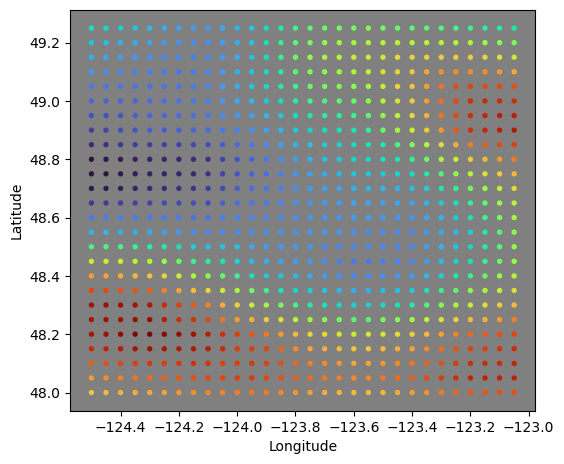

In [118]:
# Plot the results in lon/lat
fig, axi = plt.subplots(figsize=(6,6))
axi.set_aspect("equal")
axi.set_facecolor("gray")
axi.scatter(fx,fy,s=8,c=md,vmin=vmin,vmax=vmax,
            cmap=plt.cm.turbo_r)
axi.set_xlabel("Longitude")
axi.set_ylabel("Latitude")
plt.show()

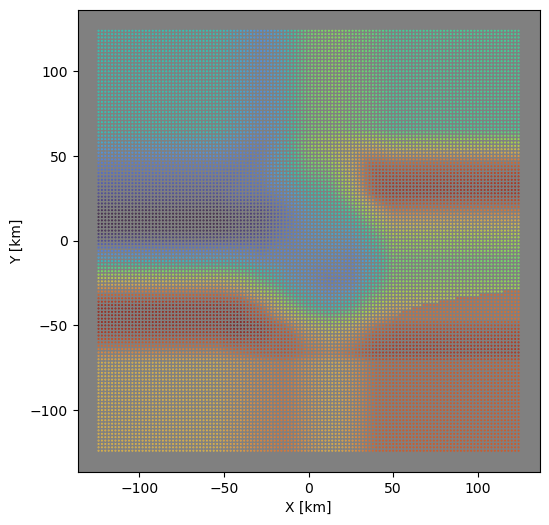

In [120]:
# Plot the results in km
test_depth = 0.0
zdf = odf.groupby("z").get_group(test_depth)
fig, axi = plt.subplots(figsize=(6,6))
axi.set_aspect("equal")
axi.set_facecolor("gray")
axi.scatter(zdf["x"],zdf["y"],s=0.15,c=zdf["vs"], vmin=vmin, vmax=vmax,
            cmap=plt.cm.turbo_r)
axi.set_xlabel("X [km]")
axi.set_ylabel("Y [km]")
plt.show()

In [121]:
# Function to fill NaN values using nearest neighbors
def fill_nan_with_nearest_neighbors(df, columns):
    for z_val in df['z'].unique():
        subset = df[df['z'] == z_val]
        for col in columns:
            mask = subset[col].notna()
            points = subset[mask][['x', 'y']].values
            values = subset[mask][col].values
            grid = subset[['x', 'y']].values
            filled_values = interpolate.griddata(points, values, grid, method='nearest')
            df.loc[df['z'] == z_val, col] = filled_values
    return df

# Fill NaN values for vp and vs
odf = fill_nan_with_nearest_neighbors(odf, ['vp', 'vs'])
if not df[['vp', 'vs']].isna().any().any():
    print('NaN disappeared!')

NaN disappeared!


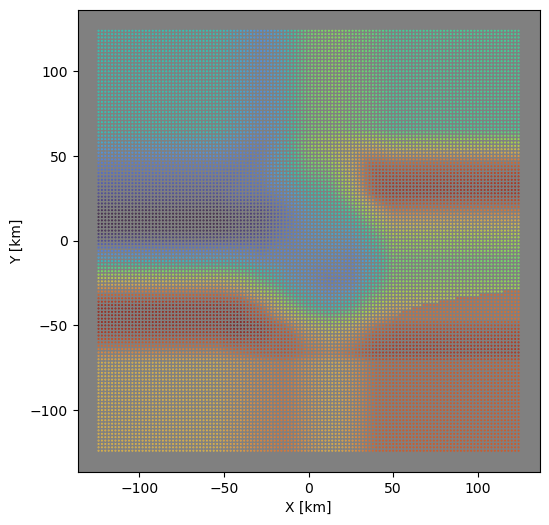

In [122]:
# See the final result for the same depth
zdf = odf.groupby("z").get_group(test_depth)
fig, axi = plt.subplots(figsize=(6,6))
axi.set_aspect("equal")
axi.set_facecolor("gray")
axi.scatter(zdf["x"],zdf["y"],s=0.15,c=zdf["vs"], vmin=vmin, vmax=vmax,
            cmap=plt.cm.turbo_r)
axi.set_xlabel("X [km]")
axi.set_ylabel("Y [km]")
plt.show()

It seems than in this case I don't have much NaN values so no big changes.

## Write the SimulPS.txt files

In [125]:
# Filename for local; will go in the model folder later
output_filename_P=f'Savard_{pproj}_{maxR}_P.txt'
with open('output_filename_P',"w") as f:
    
    # Header line
    unit, nph = 1.0, 2 # grid units are 1km, 2 phases
    f.writelines("%f %d %d %d %d # SimulPS P-wave Model\n" %(unit,nx,ny,nz,nph))
    
    # Write xgrid, ygrid, zgrid
    s = " ".join("%.1f" %x for x in xg) + "\n"
    f.writelines(s)
    s = " ".join("%.1f" %y for y in yg) + "\n"
    f.writelines(s)
    s = " ".join("%.1f" %z for z in zg) + "\n"
    f.writelines(s)
    
    # Dummy lines
    f.writelines("0 0 0\n\n")
    
    # Loop over z, then y, then write all x
    gdf = odf.groupby(["z","y"])
    for zval in zg:
        for yval in yg:
            df = gdf.get_group((zval,yval))
            vdata = df["vp"].values
            s = " ".join("%.2f" %v for v in vdata) + "\n"
            f.writelines(s)

# Completed everything
print(f"Data written to {output_filename_P}.")

Data written to Savard_lcc_200R_P.txt.


In [126]:
# Filename for local; will go in the model folder later
output_filename_S=f'Savard_{pproj}_{maxR}_S.txt'
with open('output_filename_S',"w") as f:
    
    # Header line
    unit, nph = 1.0, 2 # grid units are 1km, 2 phases
    f.writelines("%f %d %d %d %d # SimulPS S-wave Model\n" %(unit,nx,ny,nz,nph))
    
    # Write xgrid, ygrid, zgrid
    s = " ".join("%.1f" %x for x in xg) + "\n"
    f.writelines(s)
    s = " ".join("%.1f" %y for y in yg) + "\n"
    f.writelines(s)
    s = " ".join("%.1f" %z for z in zg) + "\n"
    f.writelines(s)
    
    # Dummy lines
    f.writelines("0 0 0\n\n")
    
    # Loop over z, then y, then write all x
    gdf = odf.groupby(["z","y"])
    for zval in zg:
        for yval in yg:
            df = gdf.get_group((zval,yval))
            vdata = df["vs"].values
            s = " ".join("%.2f" %v for v in vdata) + "\n"
            f.writelines(s)

# Completed everything
print(f"Data written to {output_filename_S}.")

Data written to Savard_lcc_200R_S.txt.


# Notes

Loïc's steps are:
1. Dividing the area in polygons
2. Load velocity model
3. Transform it into an xarray with cartesian coordinates
4. Extrapolate vertically and interpolate horizontally
5. Save it to .netcdf
6. Project the new model in lat/lon on the polygons
7. Change it to a dataframe
8. Save the SimulPS .txt files <br>

For SVI, the area doesn't need to be divided. The interpolation is used on a subset of the model (small area) and done with griddata to get more grid points. Every coordinates stays in lat/lon and I keep the original depths. It can be diretly save in the .txt files.